# fscLVM tutorial 

In this notebook we illustrate how f-scLVM can be used to identify biological processes driving variability between cells. 

First, we load some modules and set some directories

In [1]:
import sys
import os
import scipy as SP
import cPickle as pickle
import fscLVM
from fscLVM import plotFactors, plotFA, saveFA, dumpFA
%load_ext rpy2.ipython
%pylab inline

#specify where the hdf5 file is
data_dir = '../../../data/'
out_dir = './../results/'



Populating the interactive namespace from numpy and matplotlib


f-scLVM expects a hdf file containing the normalised, log transformed gene expression data as well as a set of annotations. We provide an R script (in the R folder) which can be used to generate this input from a gene expression matrix, using annotation from REACTOME, MSigDB and Wikipathways. 

Usage is also illustrated in the next R cell; it can be skipped and provided hdf file can be used instead.





# Generating an input file using R 

In [3]:
%%R -i data_dir
#This illustrates the generation of input files using R; alternatatively a hdf5 fie containing the necessary daat is provided. 
library(rhdf5)
library(gplots)
require(GSEABase)
require(limma)
source('../../../R/Rutils.R')

#zipped csv file contains normalised read counts of variable genes and cell cycle stage as in Buettner et al
Ydf = read.csv2(unz(paste0(data_dir,'BuettneretalT.csv.zip'), 'BuettneretalT.csv'), sep=';',check.names=F)
Y = t(as.matrix(Ydf[,2:dim(Ydf)[2]]))

print(Y[1:5,1:5])

#cell cycle stage
labels = Ydf[,1]

#we also write out the cell cycle phase information that can be used either as covariate in the model or for plottting
modelMat = model.matrix(~as.factor(labels))[,2:3]
Known = cbind(modelMat)
colnames(Known) = paste("ccPhase",c("S", "G2M"),sep="")


#if you have custom gene sets add them here
#setsAdd = list()
#setsAdd[[1]]=custom_genes
#setsAdd_names = 'XXX'

#to generate the annotation matrix for MSigDB, dowload the annotation file from GSEA and put it in the data folder; 
#unfortunately we cannot provide it due to copyright restrictions. URL: http://software.broadinstitute.org/gsea/msigdb/collections.jsp#H
write_scLVM2(Y, 'Buettneretal2015.hdf5', Known=Known, data_dir=data_dir)

/usr/local/lib/python2.7/site-packages/rpy2-2.8.0.dev0-py2.7-macosx-10.10-x86_64.egg/rpy2/robjects/functions.py:106: UserWarning: 
Attache Paket: ‘gplots’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2-2.8.0.dev0-py2.7-macosx-10.10-x86_64.egg/rpy2/robjects/functions.py:106: UserWarning: Das folgende Objekt ist maskiert ‘package:stats’:

    lowess


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2-2.8.0.dev0-py2.7-macosx-10.10-x86_64.egg/rpy2/robjects/functions.py:106: UserWarning: Lade nötiges Paket: GSEABase

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2-2.8.0.dev0-py2.7-macosx-10.10-x86_64.egg/rpy2/robjects/functions.py:106: UserWarning: Lade nötiges Paket: BiocGenerics

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2-2.8.0.dev0-py2.7-macosx-1

          [,1]      [,2]     [,3]      [,4]      [,5]
Gnai3 1.975628 0.8049608 2.179647 1.5750736 2.8750169
Cdc45 2.834534 1.0705594 1.800479 1.7385036 0.7962692
H19   0.000000 0.0000000 0.000000 0.0000000 0.0000000
Scml2 0.000000 0.0000000 2.830066 0.5105733 0.0000000
Narf  1.355539 0.0000000 1.261695 0.6751993 0.6535729


# Loading data

Arguments specify some options, incuding number of hidden factors (`nHidden`), minimum number of genes in a pathway (`minGenes`), whether to use the fast option by pruning genes (`pruneGenes`), noise model (`noise`) and the data directory (`data_dir`).

In [2]:
dFile = 'Buettneretal2015.hdf5'

data = fscLVM.load_hdf5(dFile, data_dir=data_dir)
#my hack to load old data file
I = data['IMSigDB']
Y = data['Y']
terms = data['terms']


FA = fscLVM.initFA(Y, terms,I,noise='gauss', nHidden=3, 
                   pruneGenes=True, minGenes=15)
#iterate
FA.iterate(nIterations=2000)

#print diagnostics
FA.printDiagnostics()


iteration 0
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
Converged after 701 iterations
Maximally  4.6875 % Genes per factor changed.


Next, we plot the results, including  factor relevance, gene set augmentation and a scatter plot of the two most relevant factors, in this case G2M Checkpoint and P53 Pathway. 

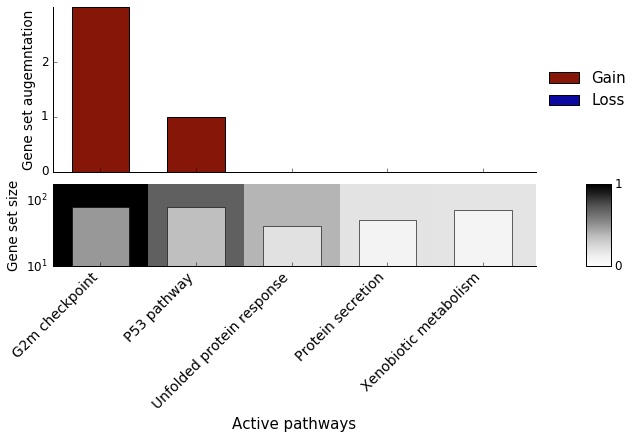

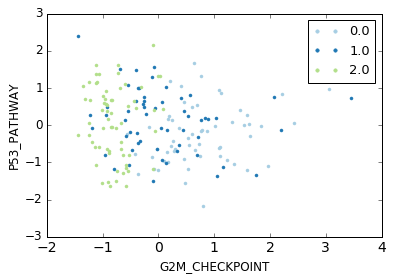

In [3]:
#plot resutls
plotFA(FA)

#scatter plot of factors
plotFactors(FA,0,1, lab = data['Known'][0,:]+2*data['Known'][1,:], isCont=False )



Finally, we can dump the results in a dictionary and/or hdf file.

In [3]:
saveFA(FA)
dataFA = dumpFA(FA)
print dataFA.keys()

['terms', 'I', 'W', 'idx_genes', 'relevance', 'X', 'Z']
